In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

In [3]:
np.random.seed(42)
torch.manual_seed(42)

## Kraichnan-Orszag Three-Mode Problem

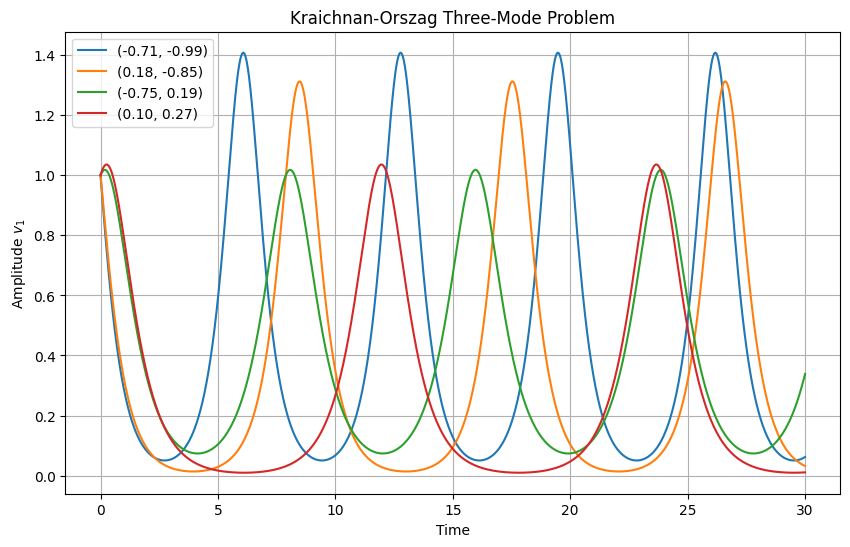

In [4]:
initial_settings = [
    [-0.71, -0.99], 
    [0.18, -0.85],
    [-0.75, 0.19],
    [0.10, 0.27]]


t = np.linspace(0, 30, 10000)

plt.figure(figsize=(10, 6))

dataset = []

for i, v0 in enumerate(initial_settings, start=1):

    v0 = [1.0, 0.1*v0[0], 1.0*v0[1]]
    v = odeint(system, v0, t)

    dataset.append(v[:, 0])
    plt.plot(t, v[:, 0], label=f"({10*v0[1]:.2f}, {v0[2]:.2f})")
    
dataset = np.array(dataset)


plt.xlabel('Time')
plt.ylabel('Amplitude $v_1$')
plt.title('Kraichnan-Orszag Three-Mode Problem')
plt.legend()
plt.grid(True)
plt.show()

## Parameter Sampling

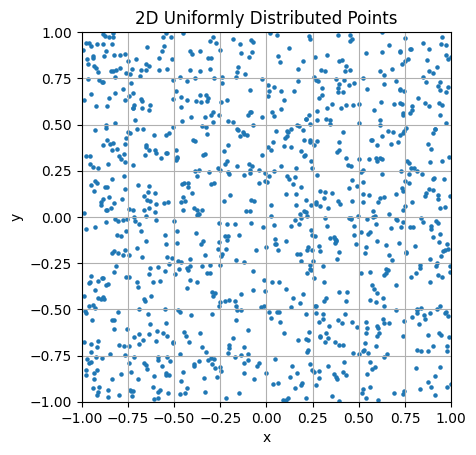

In [5]:
num_samples = 1024


x_points = np.empty(num_samples)
y_points = np.empty(num_samples)


for i in range(num_samples):
    x, y = sample_point()
    x_points[i] = x
    y_points[i] = y


plt.scatter(x_points, y_points, s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Uniformly Distributed Points')
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [6]:
initial_settings = np.vstack((x_points, y_points)).T

In [7]:
dataset = generate_solutions(initial_settings)

print('dataset dims:', dataset.shape)

dataset dims: (1024, 10000)


## Dimension Reduction

In [8]:
# n_components = 100
# n_components = 500
n_components = 10

In [9]:
pca = PCA(n_components=n_components, random_state=42)
PCA_reduced_data = pca.fit_transform(dataset)

/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


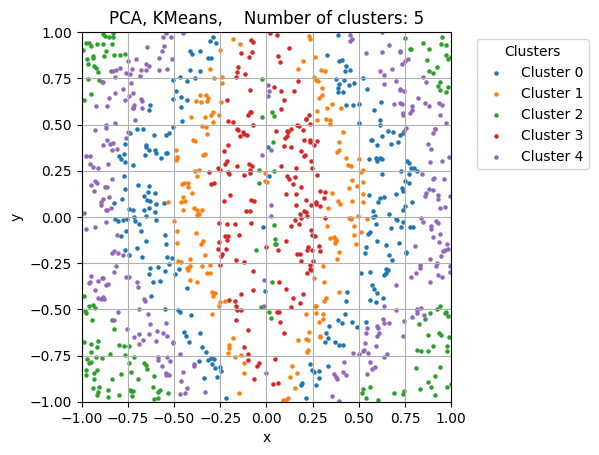

In [10]:
kmeans = KMeans(n_clusters=5, random_state=42)
PCA_labels = kmeans.fit_predict(PCA_reduced_data)

for label in np.unique(PCA_labels):
    mask = PCA_labels == label
    plt.scatter(initial_settings[mask, 0], initial_settings[mask, 1], cmap='viridis', s=5, label=f'Cluster {label}')


plt.xlabel('x')
plt.ylabel('y')
plt.title('PCA, KMeans,    ' + 'Number of clusters: ' + f"{5}")
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


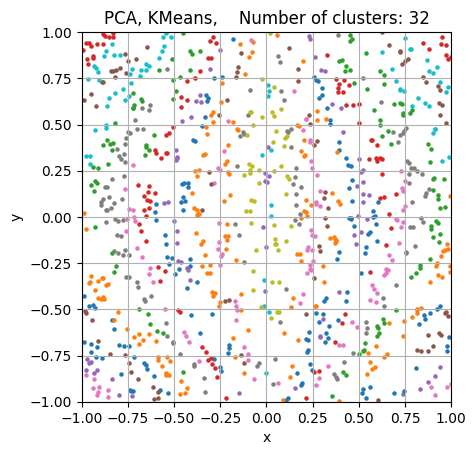

In [11]:
kmeans = KMeans(n_clusters=32, random_state=42)
PCA_labels = kmeans.fit_predict(PCA_reduced_data)

for label in np.unique(PCA_labels):
    mask = PCA_labels == label
    plt.scatter(initial_settings[mask, 0], initial_settings[mask, 1], cmap='viridis', s=5, label=f'Cluster {label}')


plt.xlabel('x')
plt.ylabel('y')
plt.title('PCA, KMeans,    ' + 'Number of clusters: ' + f"{32}")
plt.grid(True)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
# plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Multiple GPs

In [12]:
training_iter = 50

n_clusters_list = [1, 5, 10, 20, 32]
test_param_list = [[0.89,-0.07], [-0.53,0.26], [-0.03,0.81], [0.91,0.02]]

/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


selected_cluster:  0
Iter 1/50 - Loss: 25.589
Iter 11/50 - Loss: 9.296
Iter 21/50 - Loss: 4.548
Iter 31/50 - Loss: 4.057
Iter 41/50 - Loss: 3.774
Iter 50/50 - Loss: 3.533
 
selected_cluster:  0
Iter 1/50 - Loss: 25.590
Iter 11/50 - Loss: 9.297
Iter 21/50 - Loss: 4.551
Iter 31/50 - Loss: 4.057
Iter 41/50 - Loss: 3.777
Iter 50/50 - Loss: 3.532
 
selected_cluster:  0
Iter 1/50 - Loss: 25.590
Iter 11/50 - Loss: 9.298
Iter 21/50 - Loss: 4.551
Iter 31/50 - Loss: 4.058
Iter 41/50 - Loss: 3.773
Iter 50/50 - Loss: 3.531
 
selected_cluster:  0
Iter 1/50 - Loss: 25.591
Iter 11/50 - Loss: 9.299
Iter 21/50 - Loss: 4.549
Iter 31/50 - Loss: 4.057
Iter 41/50 - Loss: 3.774
Iter 50/50 - Loss: 3.530
 


/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


selected_cluster:  4
Iter 1/50 - Loss: 9.725
Iter 11/50 - Loss: 4.907
Iter 21/50 - Loss: 3.572
Iter 31/50 - Loss: 3.206
Iter 41/50 - Loss: 3.029
Iter 50/50 - Loss: 2.919
 
selected_cluster:  1
Iter 1/50 - Loss: 9.651
Iter 11/50 - Loss: 5.390
Iter 21/50 - Loss: 3.976
Iter 31/50 - Loss: 3.473
Iter 41/50 - Loss: 3.258
Iter 50/50 - Loss: 3.159
 
selected_cluster:  2
Iter 1/50 - Loss: 16.346
Iter 11/50 - Loss: 7.366
Iter 21/50 - Loss: 4.962
Iter 31/50 - Loss: 4.290
Iter 41/50 - Loss: 3.968
Iter 50/50 - Loss: 3.761
 
selected_cluster:  4
Iter 1/50 - Loss: 9.727
Iter 11/50 - Loss: 4.905
Iter 21/50 - Loss: 3.576
Iter 31/50 - Loss: 3.202
Iter 41/50 - Loss: 3.028
Iter 50/50 - Loss: 2.916
 


/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


selected_cluster:  7
Iter 1/50 - Loss: 4.829
Iter 11/50 - Loss: 3.161
Iter 21/50 - Loss: 2.670
Iter 31/50 - Loss: 2.503
Iter 41/50 - Loss: 2.415
Iter 50/50 - Loss: 2.372
 
selected_cluster:  9
Iter 1/50 - Loss: 5.519
Iter 11/50 - Loss: 3.582
Iter 21/50 - Loss: 2.990
Iter 31/50 - Loss: 2.755
Iter 41/50 - Loss: 2.653
Iter 50/50 - Loss: 2.612
 
selected_cluster:  4
Iter 1/50 - Loss: 18.359
Iter 11/50 - Loss: 10.417
Iter 21/50 - Loss: 7.383
Iter 31/50 - Loss: 5.973
Iter 41/50 - Loss: 5.338
Iter 50/50 - Loss: 5.044
 
selected_cluster:  7
Iter 1/50 - Loss: 4.828
Iter 11/50 - Loss: 3.157
Iter 21/50 - Loss: 2.674
Iter 31/50 - Loss: 2.500
Iter 41/50 - Loss: 2.423
Iter 50/50 - Loss: 2.371
 


/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


selected_cluster:  10
Iter 1/50 - Loss: 3.944
Iter 11/50 - Loss: 2.438
Iter 21/50 - Loss: 2.103
Iter 31/50 - Loss: 1.870
Iter 41/50 - Loss: 1.623
Iter 50/50 - Loss: 1.385
 
selected_cluster:  3
Iter 1/50 - Loss: 4.679
Iter 11/50 - Loss: 3.027
Iter 21/50 - Loss: 2.587
Iter 31/50 - Loss: 2.443
Iter 41/50 - Loss: 2.354
Iter 50/50 - Loss: 2.319
 
selected_cluster:  8
Iter 1/50 - Loss: 11.691
Iter 11/50 - Loss: 6.427
Iter 21/50 - Loss: 4.806
Iter 31/50 - Loss: 4.147
Iter 41/50 - Loss: 3.823
Iter 50/50 - Loss: 3.644
 
selected_cluster:  10
Iter 1/50 - Loss: 3.943
Iter 11/50 - Loss: 2.438
Iter 21/50 - Loss: 2.096
Iter 31/50 - Loss: 1.857
Iter 41/50 - Loss: 1.630
Iter 50/50 - Loss: 1.394
 


/home/gulio/anaconda3/envs/23_09/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


selected_cluster:  2
Iter 1/50 - Loss: 4.404
Iter 11/50 - Loss: 2.553
Iter 21/50 - Loss: 2.079
Iter 31/50 - Loss: 1.776
Iter 41/50 - Loss: 1.516
Iter 50/50 - Loss: 1.374
 
selected_cluster:  14
Iter 1/50 - Loss: 5.141
Iter 11/50 - Loss: 3.011
Iter 21/50 - Loss: 2.542
Iter 31/50 - Loss: 2.368
Iter 41/50 - Loss: 2.264
Iter 50/50 - Loss: 2.191
 
selected_cluster:  8
Iter 1/50 - Loss: 10.483
Iter 11/50 - Loss: 5.616
Iter 21/50 - Loss: 4.182
Iter 31/50 - Loss: 3.625
Iter 41/50 - Loss: 3.358
Iter 50/50 - Loss: 3.210
 
selected_cluster:  2
Iter 1/50 - Loss: 4.404
Iter 11/50 - Loss: 2.553
Iter 21/50 - Loss: 2.079
Iter 31/50 - Loss: 1.776
Iter 41/50 - Loss: 1.516
Iter 50/50 - Loss: 1.374
 


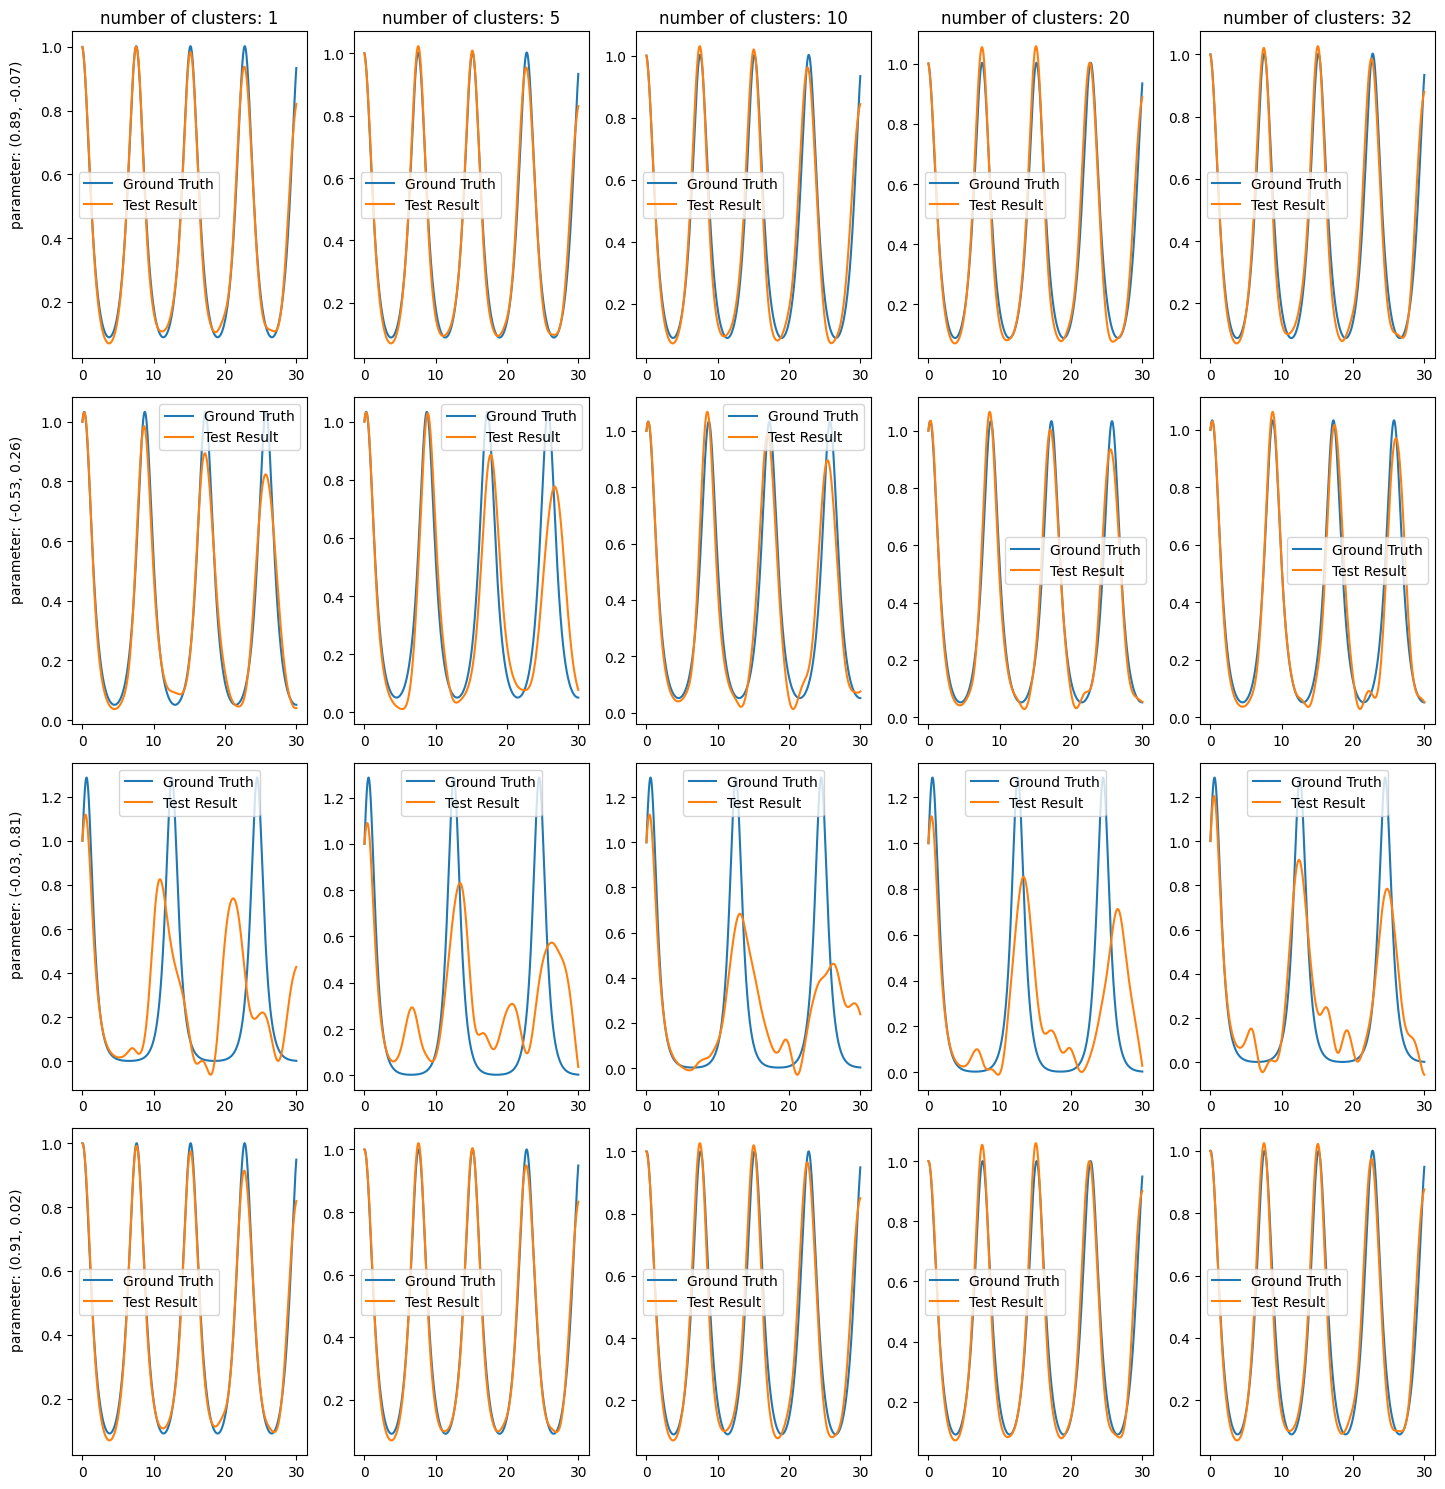

In [13]:
fig, axes = plt.subplots(len(test_param_list), len(n_clusters_list), figsize=(15, 15))


row_titles = [f'parameter: ({pair[0]:.2f}, {pair[1]:.2f})' for i, pair in enumerate(test_param_list)]
col_titles = [f'number of clusters: {n_c}' for i, n_c in enumerate(n_clusters_list)]

for ax, col_title in zip(axes[0], col_titles):
    ax.set_title(col_title)

for i, row_title in enumerate(row_titles):
    fig.text(0.04, 0.9 - i * 0.25, row_title, va='center', rotation='vertical')

    
for ax_i, n_clusters in enumerate(n_clusters_list):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    PCA_labels = kmeans.fit_predict(PCA_reduced_data)
    
    partitioned_initial_settings = []
    partitioned_PCA_reduced_data = []

    for label in range(n_clusters):
        partition = initial_settings[PCA_labels == label]
        partitioned_initial_settings.append(partition)
        partitioned_PCA_reduced_data.append(PCA_reduced_data[PCA_labels == label])

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(initial_settings, PCA_labels)
    
    for ax_j, test_param in enumerate(test_param_list):
        point = np.array([test_param])
        selected_cluster = knn.predict(point)[0]
        print('selected_cluster: ', selected_cluster)
        
        # -----------
        train_x = torch.tensor(partitioned_initial_settings[selected_cluster]).float()
        train_y = torch.tensor(partitioned_PCA_reduced_data[selected_cluster]).float()

        likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_components)
        model = MultiOutputGPModel(train_x, train_y, likelihood, n_components)

        model.train()
        likelihood.train()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            optimizer.zero_grad()
            output = model(train_x)
            loss = -mll(output, train_y)
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
            if i == training_iter-1:
                print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
                print(' ')

        model.eval()
        likelihood.eval()
        # -----------

        test_x = torch.tensor([
            test_param
        ]).float()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model(test_x))


        reconstructed = pca.inverse_transform(observed_pred.mean)[0]

        v0 = [1.0, 0.1*test_param[0], 1.0*test_param[1]]
        v = odeint(system, v0, t)

        ax = axes[ax_j][ax_i]
#         ax = axes
#         ax.set_title(f'Parameter: {test_param},    number of clusters: {n_clusters}')
#         ax.set_xlabel('Time')
#         ax.set_ylabel('Amplitude $v_1$')
        ax.plot(t, v[:, 0], label="Ground Truth")
        ax.plot(t, reconstructed, label="Test Result")
        ax.legend()

plt.tight_layout(rect=[0.05, 0, 1, 1])
# plt.show()
plt.savefig('result.pdf')
        